
--- Experiment with dataset size 10 ---
Model architecture: Sequential(
  (0): Linear(in_features=100, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=512, bias=True)
)
Total neurons in hidden layers: 1024
Total parameters: 577024
Epoch 0, Train Loss: 0.00912546
Epoch 10, Train Loss: 0.00835313
Epoch 20, Train Loss: 0.00769530
Epoch 30, Train Loss: 0.00698926
Epoch 40, Train Loss: 0.00616737
Epoch 50, Train Loss: 0.00523591
Epoch 60, Train Loss: 0.00426309
Epoch 70, Train Loss: 0.00334268
Epoch 80, Train Loss: 0.00255954
Epoch 90, Train Loss: 0.00196104
Epoch 100, Train Loss: 0.00154033
Epoch 110, Train Loss: 0.00125446
Epoch 120, Train Loss: 0.00105656
Epoch 130, Train Loss: 0.00091004
Epoch 140, Train Loss: 0.00079205
Epoch 150, Train Loss: 0.00069279
Epoch 160, Train Loss: 0.00060736
Epoch 170, Train Loss: 0.00053276
Epoch 180, Train Loss: 0.00046827
Epoch 190, Train Los

<ipython-input-2-8df2d67113bb>:53: RuntimeWarning: invalid value encountered in divide
  y_full = y_full / absmax  # 縮放到 [-1, 1] 範圍


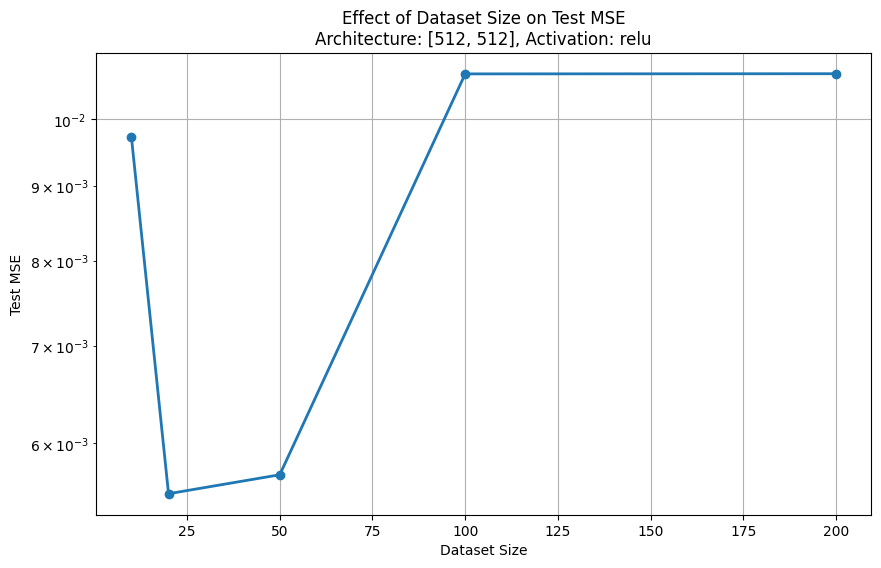


--- Experiment with architecture 1x100 ---
Model architecture: Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=512, bias=True)
)
Total neurons in hidden layers: 100
Total parameters: 61812
NaN loss encountered, aborting training or adjusting strategy.
Test MSE: 0.00899692

--- Experiment with architecture 2x100 ---
Model architecture: Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=512, bias=True)
)
Total neurons in hidden layers: 200
Total parameters: 71912
NaN loss encountered, aborting training or adjusting strategy.
Test MSE: 0.00854791

--- Experiment with architecture 3x100 ---
Model architecture: Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3

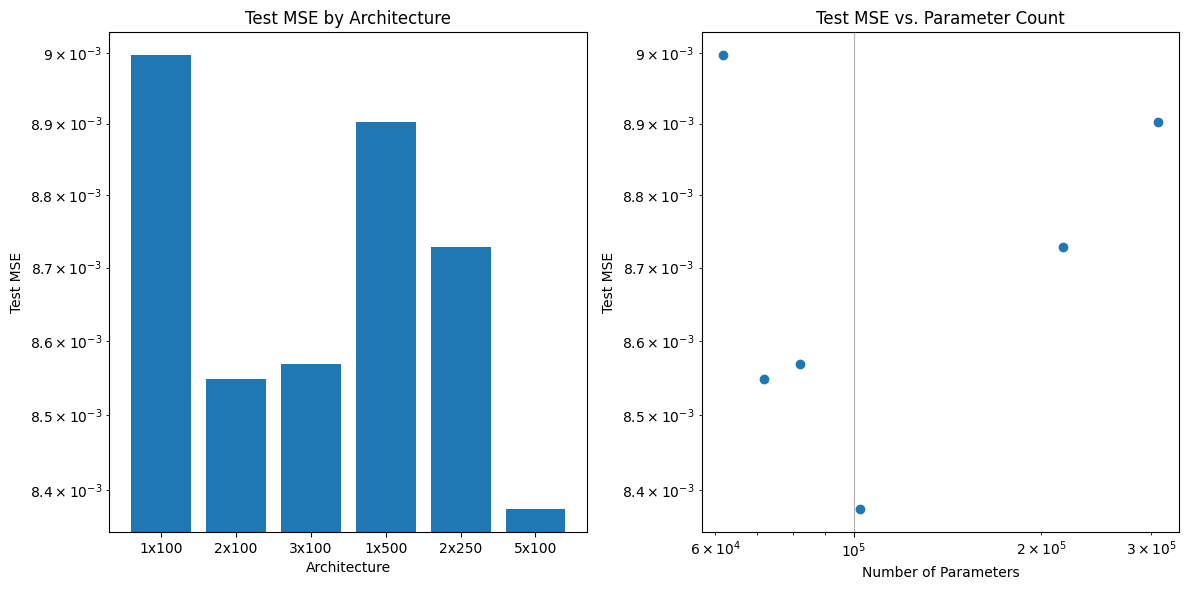


--- Experiment with activation relu ---
Model architecture: Sequential(
  (0): Linear(in_features=100, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=512, bias=True)
)
Total neurons in hidden layers: 1024
Total parameters: 577024
Epoch 0, Train Loss: 0.01066193
Epoch 10, Train Loss: 0.00844833
Epoch 20, Train Loss: 0.00645014
Epoch 30, Train Loss: 0.00474696
Epoch 40, Train Loss: 0.00380640
Epoch 50, Train Loss: 0.00257759
Epoch 60, Train Loss: 0.00234198
Epoch 70, Train Loss: 0.00230409
Epoch 80, Train Loss: 0.00204501
Epoch 90, Train Loss: 0.00184626
Epoch 100, Train Loss: 0.00171315
Epoch 110, Train Loss: 0.00163184
Epoch 120, Train Loss: 0.00165886
Epoch 130, Train Loss: 0.00171932
Epoch 140, Train Loss: 0.00176557
Epoch 150, Train Loss: 0.00161401
Epoch 160, Train Loss: 0.00172605
Epoch 170, Train Loss: 0.00176365
Epoch 180, Train Loss: 0.00149660
Epoch 190, Train Los

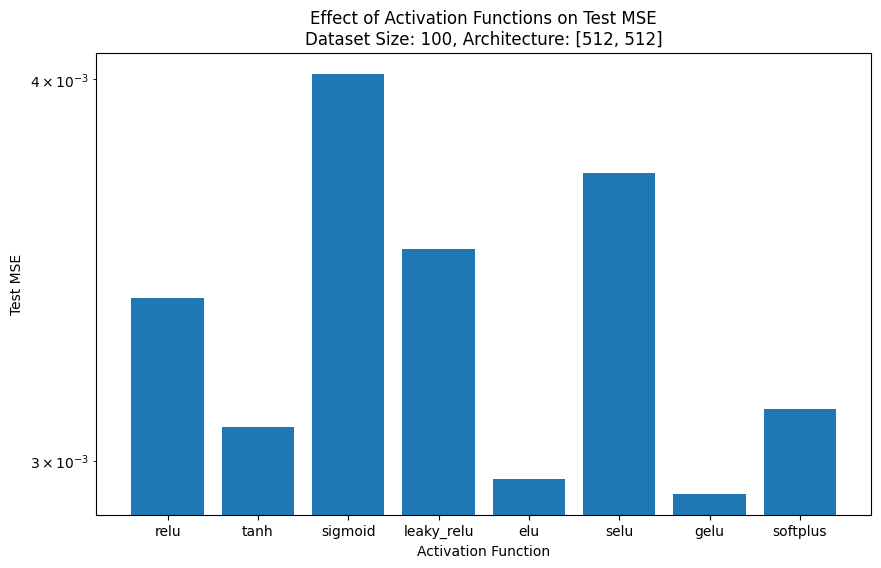

All experiments completed and results saved.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.interpolate import BarycentricInterpolator
import time
import random
from tqdm import tqdm

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Parameters
N = 512  # Full resolution
INPUT_DIM = 100  # Dimension of input (sampled points subset)
OUTPUT_DIM = 512  # Dimension of output (full resolution function)

#### NEW (B): 自訂初始化函式：Xavier Uniform + bias=0
def xavier_init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization
        nn.init.zeros_(m.bias)            # bias 初始化為 0

# Function to generate a random barycentric interpolated function
def generate_barycentric_function():
    # Full range of x values
    x_full = np.linspace(0, 1, N)

    # Generate random number of sample points between 10 and 50
    num_samples = np.random.randint(10, 51)

    # Selecting random sample points
    sample_indices = np.sort(np.random.choice(N, num_samples, replace=False))
    sample_x = x_full[sample_indices]

    # Generate random y values for our samples (between -1 and 1)
    sample_y = np.random.uniform(-1, 1, num_samples)

    # Create the barycentric interpolator
    interpolator = BarycentricInterpolator(sample_x, sample_y)

    # Get the full interpolated function
    y_full = interpolator(x_full)

    #### NEW (D): 可選的簡單資料正規化 (避免 y 值過大)
    # 若資料非常大，MSE 可能一開始就爆掉，這裡將絕對值 scale 到 [ -1, 1 ] 或 [ -10, 10 ] 皆可。
    # 您可依需求調整或移除。
    absmax = np.max(np.abs(y_full))
    if absmax > 0:
        y_full = y_full / absmax  # 縮放到 [-1, 1] 範圍

    return x_full, y_full, sample_x, sample_y, interpolator

# Generate a dataset of M barycentric functions
def generate_dataset(M, input_indices=None):
    x_full = np.linspace(0, 1, N)

    if input_indices is None:
        input_indices = np.sort(np.random.choice(N, INPUT_DIM, replace=False))

    X = np.zeros((M, INPUT_DIM))
    Y = np.zeros((M, OUTPUT_DIM))
    functions = []

    for m in range(M):
        _, y_full, _, _, _ = generate_barycentric_function()

        # Input: Function values at selected input indices
        X[m] = y_full[input_indices]
        # Output: Full resolution function
        Y[m] = y_full
        functions.append(y_full)

    return torch.FloatTensor(X), torch.FloatTensor(Y), functions

# Define neural network architecture
class InterpolationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim, activation='relu'):
        super(InterpolationNetwork, self).__init__()

        self.activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU(0.01),
            'elu': nn.ELU(),
            'selu': nn.SELU(),
            'gelu': nn.GELU(),
            'softplus': nn.Softplus()
        }

        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_layers[0]))
        layers.append(self.activations[activation])

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(self.activations[activation])

        # Output layer
        layers.append(nn.Linear(hidden_layers[-1], output_dim))

        self.model = nn.Sequential(*layers)

        # Calculate total neurons/params
        self.total_neurons = sum(hidden_layers)
        self.total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        #### NEW (B): 應用 Xavier init
        self.apply(xavier_init_weights)

    def forward(self, x):
        return self.model(x)

    def print_info(self):
        print(f"Model architecture: {self.model}")
        print(f"Total neurons in hidden layers: {self.total_neurons}")
        print(f"Total parameters: {self.total_params}")

# Training function
def train_model(model, X_train, Y_train, X_val=None, Y_val=None, epochs=500, lr=1e-4, batch_size=32):
    """
    - lr=1e-4: 降低學習率防止爆炸
    - 反向傳播後加上 gradient clipping
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = None
    if X_val is not None and Y_val is not None:
        val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # 若有任何數值為 NaN，檢查或提早中斷
            if torch.isnan(loss):
                print("NaN loss encountered, aborting training or adjusting strategy.")
                return train_losses, val_losses

            loss.backward()

            #### NEW (C): gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        val_loss = None
        if val_loader:
            model.eval()
            v_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    out = model(inputs)
                    l = criterion(out, targets)
                    v_loss += l.item()
            v_loss /= len(val_loader)
            val_losses.append(v_loss)

            # Early stopping
            if v_loss < best_val_loss:
                best_val_loss = v_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        if epoch % 10 == 0:
            if val_loader:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.8f}, Val Loss: {v_loss:.8f}")
            else:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.8f}")

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    return train_losses, val_losses if val_loader else None

def evaluate_model(model, X_test, Y_test):
    model.eval()
    with torch.no_grad():
        Y_pred = model(X_test)
        mse = nn.MSELoss()(Y_pred, Y_test).item()
    return mse, Y_pred

def visualize_results(model, X_test, Y_test, test_functions, input_indices, num_samples=5):
    model.eval()
    with torch.no_grad():
        Y_pred = model(X_test)

    x_full = np.linspace(0, 1, N)
    plt.figure(figsize=(15, 5 * min(num_samples, len(X_test))))

    for i in range(min(num_samples, len(X_test))):
        plt.subplot(min(num_samples, len(X_test)), 1, i+1)
        plt.plot(x_full, Y_test[i].numpy(), label='True Function', linewidth=2)
        plt.plot(x_full, Y_pred[i].numpy(), '--', label='DNN Prediction', linewidth=2)
        plt.scatter(x_full[input_indices], X_test[i].numpy(), c='red', label='Input Points', s=30)
        plt.title(f'Example {i+1}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('task2_predictions.png')
    plt.show()

def experiment_dataset_size(sizes, hidden_layers, activation='relu'):
    M_test = 50
    X_test, Y_test, test_functions = generate_dataset(M_test)

    results = {}
    for size in sizes:
        print(f"\n--- Experiment with dataset size {size} ---")
        X_train, Y_train, _ = generate_dataset(size)
        model = InterpolationNetwork(INPUT_DIM, hidden_layers, OUTPUT_DIM, activation)
        model.print_info()
        train_losses, _ = train_model(model, X_train, Y_train)

        test_mse, _ = evaluate_model(model, X_test, Y_test)
        print(f"Test MSE: {test_mse:.8f}")
        results[size] = {'test_mse': test_mse, 'train_losses': train_losses}

    plt.figure(figsize=(10, 6))
    x = list(results.keys())
    y = [results[size]['test_mse'] for size in x]
    plt.plot(x, y, 'o-', linewidth=2)
    plt.title(f'Effect of Dataset Size on Test MSE\nArchitecture: {hidden_layers}, Activation: {activation}')
    plt.xlabel('Dataset Size')
    plt.ylabel('Test MSE')
    if all(val > 0 for val in y):
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.grid(True)
    plt.savefig('task2_dataset_size_comparison.png')
    plt.show()

    return results

def experiment_architecture(dataset_size, architectures, activation='relu'):
    M_test = 50
    X_test, Y_test, test_functions = generate_dataset(M_test)
    X_train, Y_train, _ = generate_dataset(dataset_size)

    results = {}
    for arch in architectures:
        arch_name = f"{len(arch)}x{arch[0]}"
        print(f"\n--- Experiment with architecture {arch_name} ---")
        model = InterpolationNetwork(INPUT_DIM, arch, OUTPUT_DIM, activation)
        model.print_info()
        train_losses, _ = train_model(model, X_train, Y_train)

        test_mse, _ = evaluate_model(model, X_test, Y_test)
        print(f"Test MSE: {test_mse:.8f}")

        results[arch_name] = {
            'test_mse': test_mse,
            'train_losses': train_losses,
            'total_neurons': sum(arch),
            'total_params': model.total_params
        }

    plt.figure(figsize=(12, 6))
    arch_names = list(results.keys())
    test_mses = [results[name]['test_mse'] for name in arch_names]
    neuron_counts = [results[name]['total_neurons'] for name in arch_names]
    param_counts = [results[name]['total_params'] for name in arch_names]

    # Primary plot
    plt.subplot(1, 2, 1)
    plt.bar(arch_names, test_mses)
    plt.title('Test MSE by Architecture')
    plt.xlabel('Architecture')
    plt.ylabel('Test MSE')
    if all(v > 0 for v in test_mses):
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.grid(True, axis='y')

    # Secondary plot
    plt.subplot(1, 2, 2)
    plt.scatter(param_counts, test_mses)
    plt.title('Test MSE vs. Parameter Count')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Test MSE')
    if all(v > 0 for v in test_mses):
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.xscale('log')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('task2_architecture_comparison.png')
    plt.show()

    return results

def experiment_activation(dataset_size, hidden_layers, activations=['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu']):
    M_test = 50
    X_test, Y_test, test_functions = generate_dataset(M_test)
    X_train, Y_train, _ = generate_dataset(dataset_size)

    results = {}
    for activation in activations:
        print(f"\n--- Experiment with activation {activation} ---")
        model = InterpolationNetwork(INPUT_DIM, hidden_layers, OUTPUT_DIM, activation)
        model.print_info()
        train_losses, _ = train_model(model, X_train, Y_train)

        test_mse, _ = evaluate_model(model, X_test, Y_test)
        print(f"Test MSE: {test_mse:.8f}")

        results[activation] = {'test_mse': test_mse, 'train_losses': train_losses}

    plt.figure(figsize=(10, 6))
    activation_names = list(results.keys())
    test_mses = [results[name]['test_mse'] for name in activation_names]
    plt.bar(activation_names, test_mses)
    plt.title(f'Effect of Activation Functions on Test MSE\nDataset Size: {dataset_size}, Architecture: {hidden_layers}')
    plt.xlabel('Activation Function')
    plt.ylabel('Test MSE')
    if all(v > 0 for v in test_mses):
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.grid(True, axis='y')
    plt.savefig('task2_activation_comparison.png')
    plt.show()

    return results

def run_all_experiments():
    # Test different dataset sizes
    dataset_sizes = [10, 20, 50, 100, 200]
    hidden_layers = [512, 512]  # 2 hidden layers with 512 neurons each
    dataset_results = experiment_dataset_size(dataset_sizes, hidden_layers)

    # Test different network depths (some examples)
    dataset_size = 100
    architectures = [
        [100],
        [100, 100],
        [100, 100, 100],
        [500],
        [250, 250],
        [100, 100, 100, 100, 100]
    ]
    architecture_results = experiment_architecture(dataset_size, architectures)

    # Test different activation functions
    activations = ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu', 'selu', 'gelu', 'softplus']
    activation_results = experiment_activation(dataset_size, hidden_layers, activations)

    # Save results
    results = {
        "dataset_sizes": dataset_results,
        "network_architectures": architecture_results,
        "activations": activation_results
    }
    return results

if __name__ == "__main__":
    all_results = run_all_experiments()

    import json
    with open("experiment_results.json", "w") as f:
        json.dump(all_results, f, indent=4)

    print("All experiments completed and results saved.")
